In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

## Step 1: Distortion Correction

In this step, I used a series of chess-board images to calibrate the camera. Each chess-board images has 9x6 corners inside. I map these corners with a norm grid to calculate the camera calibration matrix and distortion coefficients.

This function is validated by applying to several road images.

In [2]:
%matplotlib inline
nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for i, f in enumerate(images):
    img = mpimg.imread(f)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

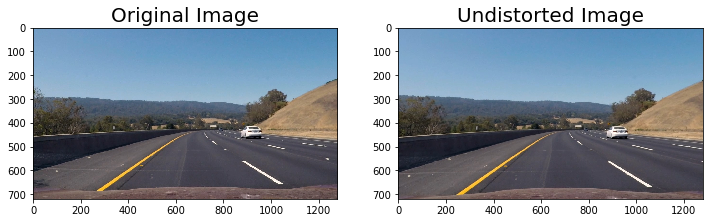

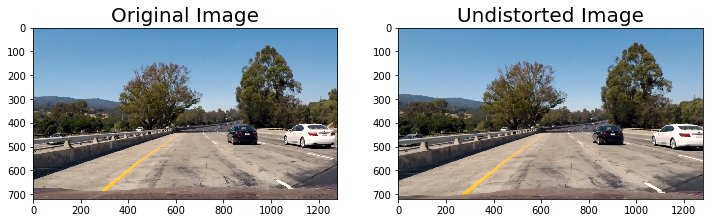

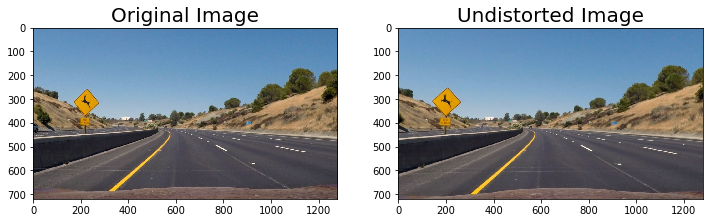

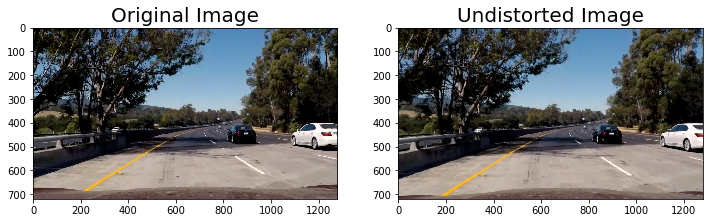

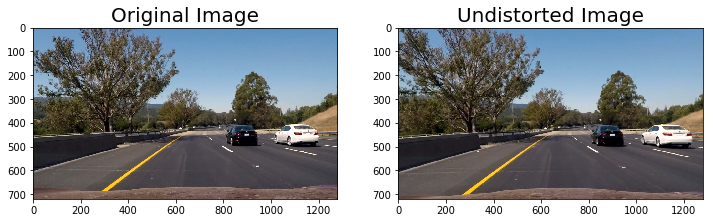

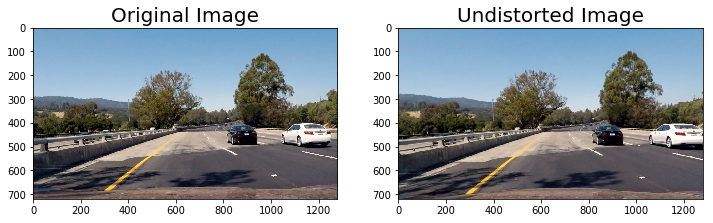

In [133]:
# Remove distortion from images
def undistort(img, show=False):
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=20)
    
    return undist

# Test the function on road images
images = glob.glob('test_images/test*.jpg')
for image in images:
    img = mpimg.imread(image)
    undistort(img, show=True)

## Step 2: Perspective Transform

This step transforms the undistorted image to a "bird-eye view" of the road, which is a view from above. To do that, we need to map two straight lanes to two parallel lines under bird-eye view. This will facilitate polynomial fitting to the lane lines and measuring the curvature in the next step.

#### First, use the warped sample picture to get the coordinates.

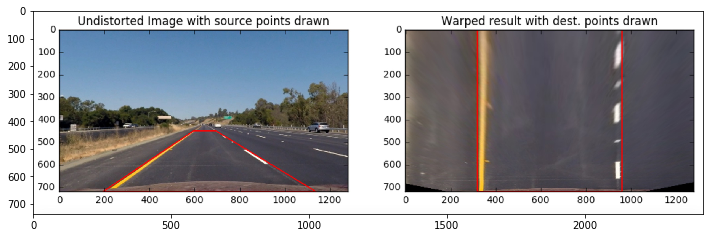

In [136]:
warped_sample = mpimg.imread('examples/warped_straight_lines.jpg')
plt.figure(figsize=(12,4))
plt.imshow(warped_sample)

$src = np.float32([[200, 720],[600, 450], [700, 450],[1100, 720]])$

$dst = np.float32([[200, 720], [200, 0], [1000, 0],[1000, 720]])$

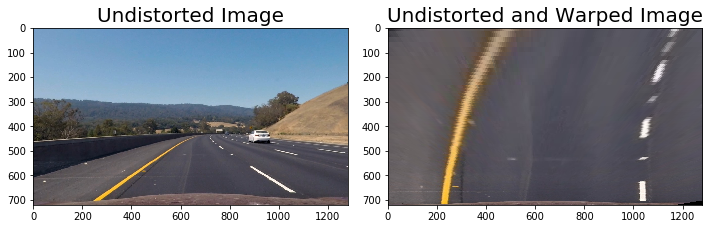

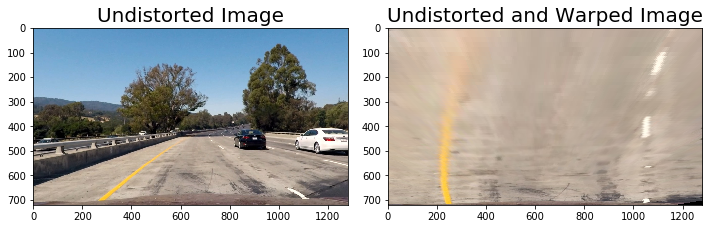

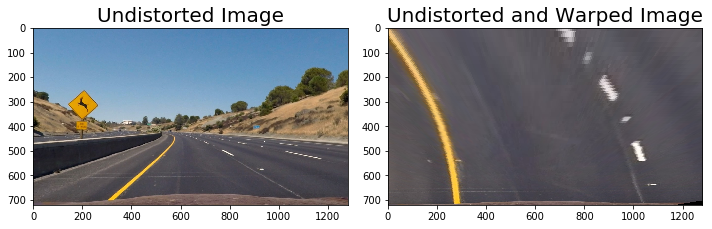

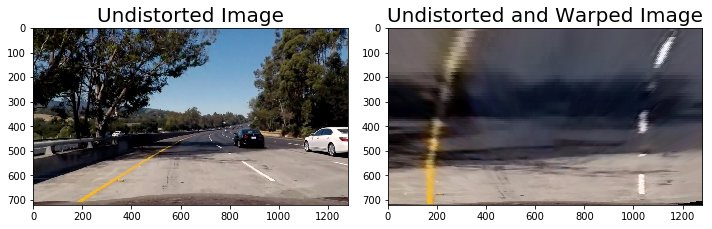

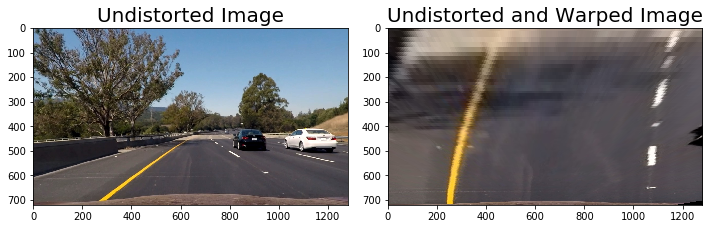

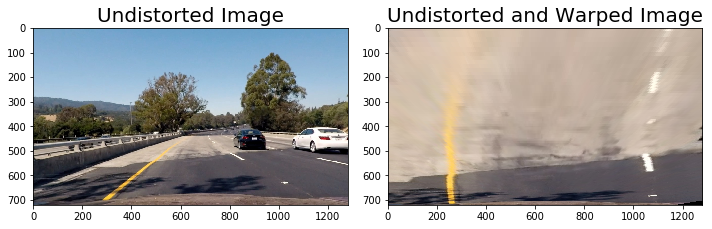

In [36]:
# Perform perspective transform
def birds_eye(undist, show=False):
    
    img_size = (undist.shape[1], undist.shape[0])
    '''src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])'''
    src = np.float32([[200, img_size[1]],[600, 450],
                      [700, 450],[1100, img_size[1]]])
    dst = np.float32([[200, img_size[1]], [200, 0], 
                     [1000, 0],[1000, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_NEAREST)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        ax1.imshow(undist)
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(warped)
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        fig.tight_layout()
    
    return warped, M

for image in glob.glob('test_images/test*.jpg'):
    img = mpimg.imread(image)
    undist = undistort(img, show=False)
    birds_eye(undist, show=True)


## Step 3: Apply Binary Thresholds

Now we convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. The following color channels and thresholds did a good job of identifying the lane lines in the provided test images:

1. The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
2. The L Channel from the LUV color space, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
3. The B channel from the Lab color space, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines.
4. Sobel filter applied directly on images does not help.

Combination of thresholded images does a great job of highlighting almost all of the white and yellow lane lines.

The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.

In [137]:
# Apply sobel-related thresholds
def sobel_xy(gray, sobel_kernel=3):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobelx, sobely

def sobel_thresh(img, sobel_kernel=3, thresh_x=(8, 100), thresh_y=(8, 100),
                    thresh_mag=(12, 100), thresh_dir=(np.pi/4-0.1, np.pi/4+0.1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient
    #sobelx, sobely = sobel_xy(gray, sobel_kernel=3)
    #abs_sobelx = np.absolute(sobelx)
    #abs_sobely = np.absolute(sobely)
    
    sobelx, sobely = sobel_xy(gray, sobel_kernel=9)
    mag_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    #sobelx, sobely = sobel_xy(gray, sobel_kernel=15)
    #dir_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Rescale back to 8 bit integer
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    scaled_sobelmag = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a copy and apply the threshold
    #binary_x = np.zeros_like(gray)
    #binary_x[(scaled_sobelx > thresh_x[0]) & (scaled_sobelx < thresh_x[1])] = 1
    #binary_y = np.zeros_like(gray)
    #binary_y[(scaled_sobely > thresh_y[0]) & (scaled_sobely < thresh_y[1])] = 1'''
    
    binary_mag = np.zeros_like(gray)
    binary_mag[(scaled_sobelmag > thresh_mag[0]) & (scaled_sobelmag < thresh_mag[1])] = 1
    #binary_dir = np.zeros_like(gray)
    #binary_dir[((dir_sobel > thresh_dir[0]) & (dir_sobel < thresh_dir[1]))| ((dir_sobel < -thresh_dir[0]) & (dir_sobel > -thresh_dir[1]))] = 1
        
    # Return the result
    return binary_mag

# Apply S colorspace threshold
def colorspace_thresh(img, thresh_L=(225, 255), thresh_B=(155, 200), thresh_S=(180, 255)):
    S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    L = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)[:,:,0]

    B = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2] 
    
    binary_S = np.zeros_like(S)
    binary_S[(S >= thresh_S[0]) & (S <= thresh_S[1])] = 1
    binary_L = np.zeros_like(L)
    binary_L[(L >= thresh_L[0]) & (L <= thresh_L[1])] = 1
    binary_B = np.zeros_like(B)
    binary_B[(B >= thresh_B[0]) & (B <= thresh_B[1])] = 1
    
    return binary_L, binary_S, binary_B

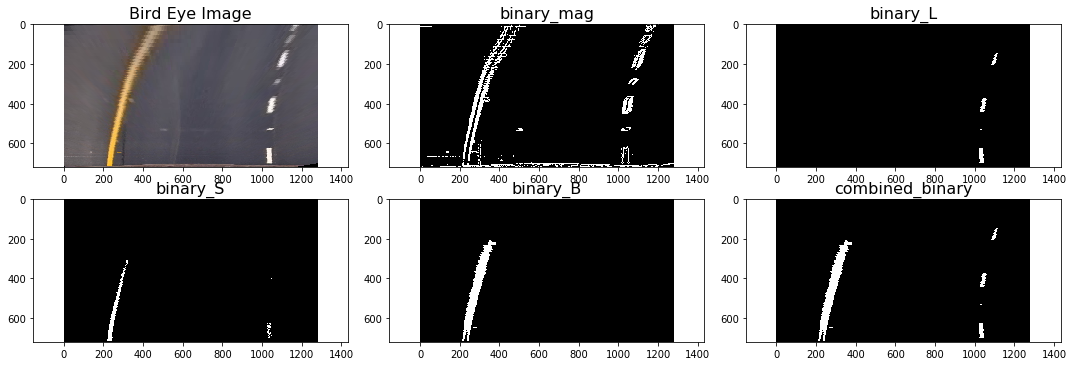

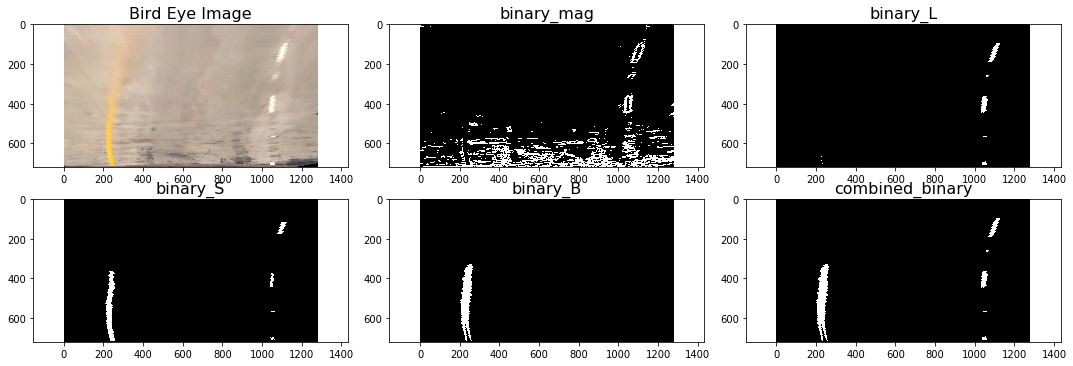

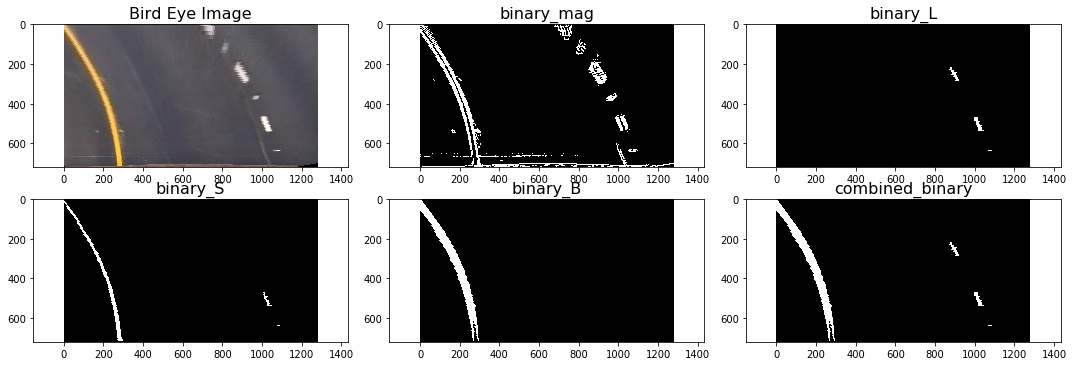

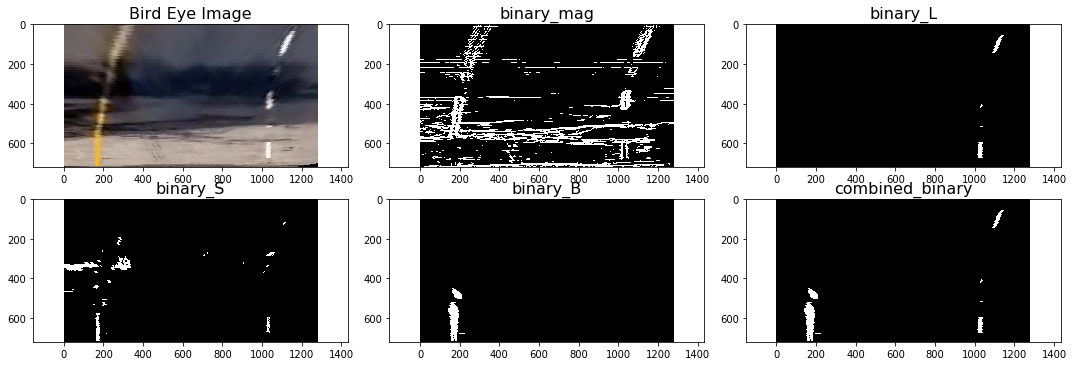

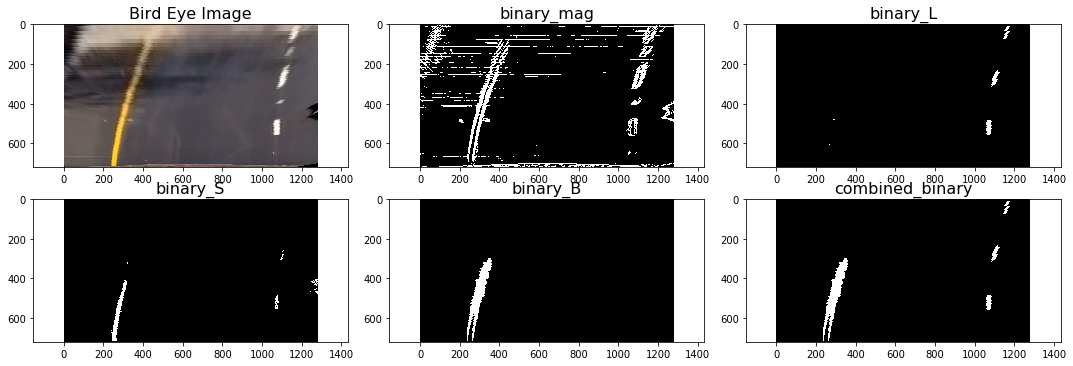

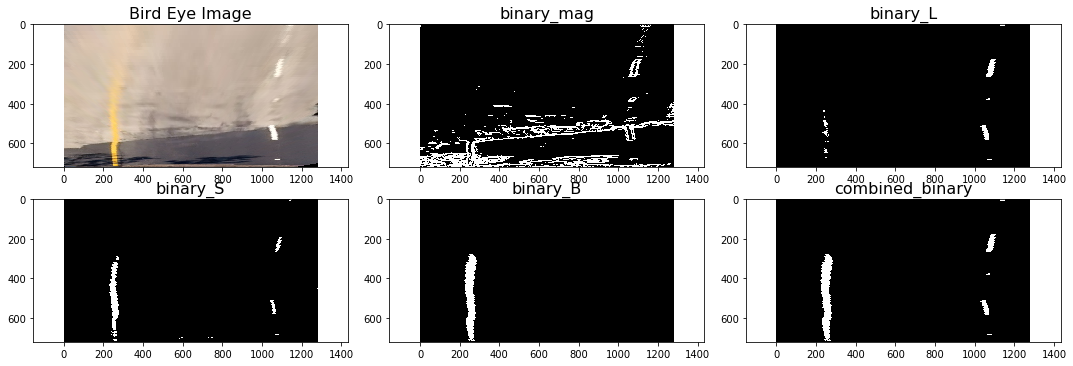

In [138]:
def combine_thresholds(img, show=False):
    
    binary_mag = sobel_thresh(img, sobel_kernel=3)
    binary_L, binary_S, binary_B = colorspace_thresh(img, 
        thresh_L=(220, 255), thresh_B=(155, 200), thresh_S=(180, 255))
    
    combined_binary = np.zeros_like(binary_mag)
    combined_binary[(binary_L == 1) | (binary_B==1)] = 1
    if show:
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, 
            sharey='col', sharex='row', figsize=(15,5))
        fig.tight_layout()

        ax1.set_title('Bird Eye Image', fontsize=16)
        ax1.imshow(img)

        ax2.set_title('binary_mag', fontsize=16)
        ax2.imshow(binary_mag, cmap='gray')
        
        ax3.set_title('binary_L', fontsize=16)
        ax3.imshow(binary_L, cmap='gray')
        
        ax4.set_title('binary_S', fontsize=16)
        ax4.imshow(binary_S, cmap='gray')
        
        ax5.set_title('binary_B', fontsize=16)
        ax5.imshow(binary_B, cmap='gray')
        
        ax6.set_title('combined_binary', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
    return combined_binary
    
for image in glob.glob('test_images/test*.jpg'):
    img = mpimg.imread(image)
    undist = undistort(img)
    bird_eye, _ = birds_eye(undist)
    combine_thresholds(bird_eye, show=True)

## Step 4: Polynomial Fitting, Calculating Vehicle Position and Radius of Curvature:

The combined binary image is used to isolate lane line pixels. Lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks. I fit a polynomial to each of the lane lines. After that, I use the equation of radius of curvature can be found at http://mathworld.wolfram.com/RadiusofCurvature.html.

The space in between the identified lane lines is filled with green color to highlight the driveable area on the road. The position of the vehicle was measured by taking the average of the x intercepts of each line.

A more robust approach is discussed here https://medium.com/towards-data-science/robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3.

In [143]:
def lane_overlay(image, show=False):
    img = image
    undist = undistort(img)
    bird_eye, _ = birds_eye(undist)
    combined_binary = combine_thresholds(bird_eye)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 20./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[200, img_size[1]],[600, 450],
                      [700, 450],[1100, img_size[1]]])
    dst = np.float32([[200, img_size[1]], [200, 0], 
                     [1000, 0],[1000, img_size[1]]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(bird_eye)
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fitx, lefty, color='green', linewidth=3)
        ax1.plot(right_fitx, righty, color='green', linewidth=3)
        ax1.set_title('Polynomial Fitting for Lanes', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images
        ax2.imshow(result)
        ax2.set_title('Filling Area Between Polynomials', fontsize=16)
        if center < 640:
            ax2.text(100, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                     style='italic', color='orange', fontsize=10)
        else:
            ax2.text(100, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                     style='italic', color='orange', fontsize=10)
        ax2.text(100, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
                 style='italic', color='orange', fontsize=10)
        
    return result

### Lane boundaries and numerical estimation of lane curvature and vehicle position.

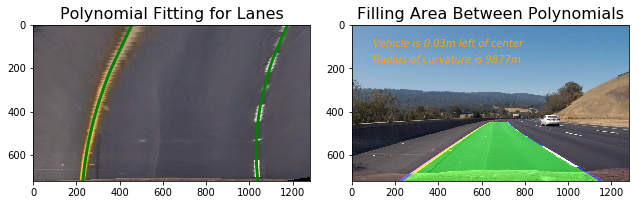

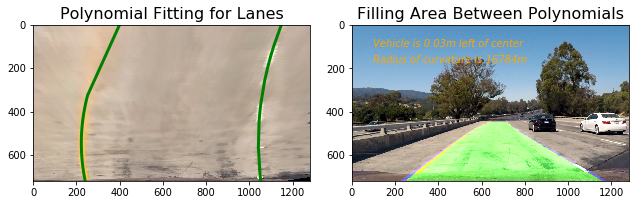

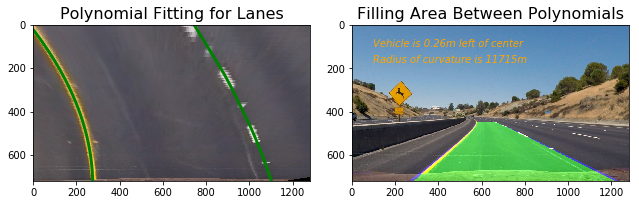

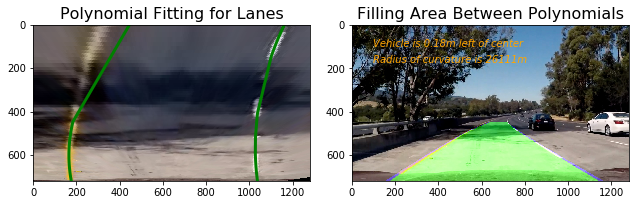

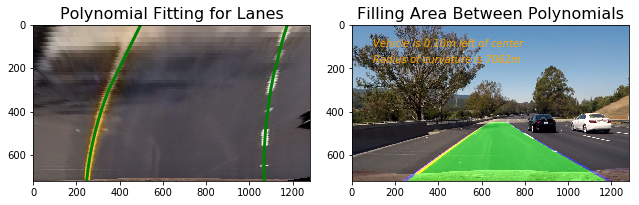

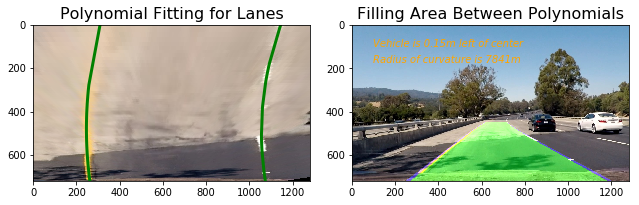

In [144]:
# Uncomment the lines below to test on sample images of the video
for image in glob.glob('test_images/test*.jpg'):
    img = mpimg.imread(image)
    lane_overlay(img, show=True)

#clip1 = VideoFileClip("project_video.mp4")
#clip1.write_images_sequence('output_images/frame%04d.jpeg', fps=0.1)
#for image in glob.glob('output_images/frame*.jpeg'):
    #img = mpimg.imread(image)
    #lane_overlay(img, show=True)

## Step 5: Video Processing Pipeline

Base implementation for lane memory can be found here https://github.com/JustinHeaton/Advanced-Lane-Finding/blob/master/Lane_Finding.ipynb.

In [157]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 20./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [158]:
# Video Processing Pipeline
def pipe_line(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[200, img_size[1]],[600, 450],
                      [700, 450],[1100, img_size[1]]])
    dst = np.float32([[200, img_size[1]], [200, 0], 
                     [1000, 0],[1000, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255, 153, 0), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255, 153, 0), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (100,140),
             fontFace = 16, fontScale = 2, color=(255, 153, 0), thickness = 2)
    Left.count += 1
    return result

### Initiate the Left and Right lane memory, then start the processing.

In [ ]:

Left = Line()
Right = Line()
video_output = 'final_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipe_line) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video final_output.mp4
[MoviePy] Writing video final_output.mp4


 19%|█▊        | 236/1261 [06:14<25:58,  1.52s/it]

In [164]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('final_output.mp4'))